In [1]:
using Plots
using SpecialFunctions
using LinearAlgebra
using PyCall
const special = pyimport("scipy.special")

PyObject <module 'scipy.special' from '/Users/fumi/.julia/conda/3/lib/python3.7/site-packages/scipy/special/__init__.py'>

In [2]:
include("CompQM.jl")

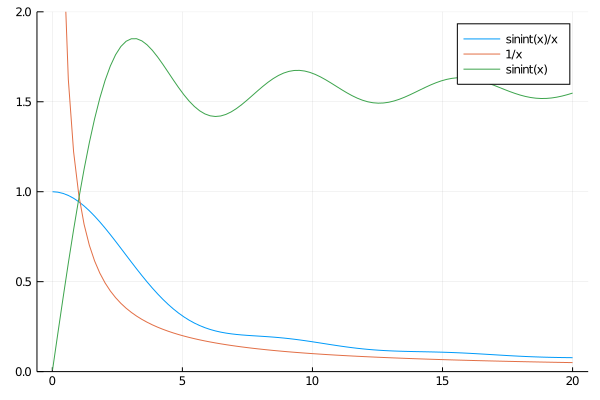

In [3]:
xs = range(1e-2, 20, length=100)
ψ = zeros(Float64, length(xs))
@. ψ = sinint(xs)/xs
plot(xs, ψ, label="sinint(x)/x", ylim=(0,2))
plot!(xs, 1 ./xs, label="1/x")
plot!(xs, sinint.(xs), label="sinint(x)")

In [4]:
module My

Base.@kwdef struct Parameters
    Z::Int64 # proton number
    N::Int64 # neutron number
    A::Int64 = Z + N # mass number
    
    Zc::Int64 = Z # proton number of core nucleus
    Nc::Int64 = N - 2 # neutron number of core nucleus
    Ac::Int64 = Zc + Nc # mass number of core nucleus
    
    mc² = 938 # rest energy of nucleon
    ħc = 197 
    
    # Woods-Saxon parameters
    a::Float64 = 0.67
    r₀::Float64 = 1.27
    R::Float64 = r₀*Ac^(1/3)
    κ::Float64 = 0.44
    
    # strength of potential for core nucleons
    V₀::Float64 = -52
    V₁::Float64 = 33
    
    # strength of potential for valence neutrons
    Vvalence::Float64 = -30.2 
    
    # effective-interaction parameters
    v₀::Float64 = -831
    v_ρ::Float64 = 930
    P::Float64 = 1.2
    ρ₀::Float64 = 0.16
end

Base.@kwdef struct QuantumNumbers
    l::Int64 # orbital angular momentum
    j::Int64 = 1 # two times total angular momentum
    q::Int64 = 1 # isospin. q=1 and q=-1 for neutron and proton, respectively.
end

Base.@kwdef struct SingleParticleState
    E::Float64 # energy
    qnums::QuantumNumbers
    ψ::Array{Float64, 1} # radial wave function 
end

    

end

Main.My

In [5]:
pars = My.Parameters(Z=3, N=8)
rs = range(0, 40, length=160+1)[2:end]

0.25:0.25:40.0

### Woods-Saxon potential
$$
    U(r) 
    = V\left(1 - \kappa \, r_{0}^{2} \, (l \cdot s) \frac{1}{r} \frac{d}{dr}\right)
    \left[1 + \exp\left(\frac{r-R}{a}\right)\right]^{-1}
    \\
    V = V_{0} + V_{1} \frac{N-Z}{A} \tau_{3}
$$

In [6]:
"""
    calc_vpot(pars, rs, qnums; core=false)

Calculate woods-saxon plus centrifugal potential multiplied by 2mc²/ħc.
If core=true, use strength of potential for core nucleons instead of one for valence neutrons.
"""
function calc_vpot(pars, rs, qnums; core=false)
    vpot = zeros(Float64, length(rs))
    
    l = qnums.l
    j = qnums.j
    q = qnums.q
    
    a = pars.a
    r₀ = pars.r₀
    R = pars.R
    κ = pars.κ
    
    V = pars.Vvalence
    if core 
        V = pars.V₀ + pars.V₁*(pars.N - pars.Z)/pars.A*q
    end
    
    ls = (1/8)*(j*(j + 2) - 4l*(l+1) - 3)
    
    # woods-saxon potential
    @. vpot += V/(1 + exp((rs-R)/a))
    @. vpot += V*κ*r₀^2/(a*rs)*ls*exp((rs-R)/a)/(1 + exp((rs-R)/a))^2
    @. vpot *= 2pars.mc²/pars.ħc^2
    
    # centrifugal potential
    @. vpot += l*(l+1)/rs^2
    
    return vpot
end
    
function test_calc_vpot(pars, rs; l=0, j=1, q=1)
    qnums = My.QuantumNumbers(l=l,j=j,q=q)
    Vcore = calc_vpot(pars, rs, qnums; core=true)
    Vvalence = calc_vpot(pars, rs, qnums; core=false)
    plot(rs, Vcore, ylims = (-1,0.1), xlims=(0,10), label="Vcore", legend=:bottomright)
    plot!(rs, Vvalence, label="Vvalence")
    plot!([0, 10], [0.8, 0.8]*2pars.mc²/pars.ħc^2, label="0.8 MeV")
end

test_calc_vpot (generic function with 1 method)

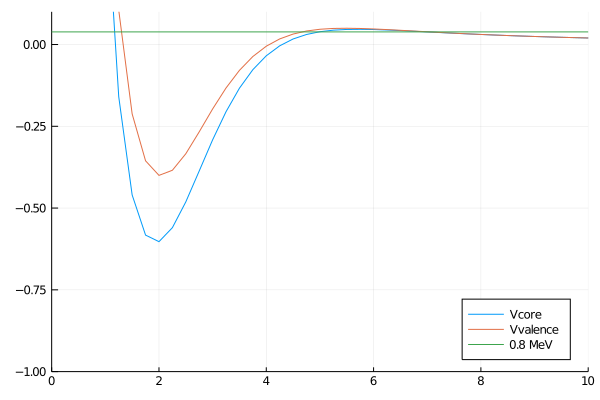

In [7]:
test_calc_vpot(pars, rs; l=1, j=1)

In [8]:
"""
    make_H1d(pars, rs, vpot)

Make Hamiltonian for radial wave function.
"""
function make_H1d(pars, rs, vpot)
    n_grids = length(rs)
    h = rs[2] - rs[1] # step size
    
    # diagonal elements
    dv = zeros(Float64, n_grids)
    @. dv = 2/h^2 + vpot
    
    # first sub/super-diagonal elements
    ev = fill(-1/h^2, n_grids-1)
    
    return SymTridiagonal(dv, ev)
end


"""
    make_H1d(pars, rs; Emax=0, Emin=-40, lmax=2, core=false, proton=false)

Diagonalize Hamiltonian for radial wave function.
Return set of s. p. states with Emin ≤ E ≤ Emax, l ≤ lmax.
If proton=true, calculate proton states as well as neutron states.
If core=true, use strength of potential for core nucleons instead of one for valence neutrons.
"""
function solve_H1d(pars, rs; Emax=0, Emin=-40, lmax=2, core=false, proton=false)
    ħc = pars.ħc
    mc² = pars.mc²
    
    h = rs[2]-rs[1] # step size
    
    # range of isospin
    qrange = 1: -2: 1 
    if proton 
        qrange = 1: -2: -1
    end
    
    states = My.SingleParticleState[] # array of s. p. states
    for l in 0:lmax, j in 2l+1: -2: max(2l-1,0), q in qrange
        qnums = My.QuantumNumbers(l=l, j=j, q=q)
        vpot = calc_vpot(pars, rs, qnums; core=core)
        
        # diagonalize H1d
        H1d = make_H1d(pars, rs, vpot)
        vals, vecs = eigen(H1d)
        
        # normalization 
        @. vals *= ħc^2/2mc²
        @. vecs /= sqrt(h)
        
        # Store s. p. states with Emin ≤ E ≤ Emax
        n₁ = length(vals[vals .< Emin])
        n₂ = length(vals[vals .≤ Emax])
        for i in n₁+1:n₂
            push!(states, My.SingleParticleState(E=vals[i], qnums=qnums, ψ=vecs[:,i]))
        end
    end
    
    states = sort_states(states) 
    return states
end

"""
    sort_states(states)

Sort states so that states[i].E ≤ states[j].E for i < j.
"""
function sort_states(states)
    n_states = length(states)
    for i in 1:n_states-1
        for j in i+1:n_states
            if states[i].E > states[j].E
                temp = states[i]
                states[i] = states[j]
                states[j] = temp
            end
        end
    end
    return states
end

"""
    show_states(states)

Show energy and quantum numbers of each s. p. states.
"""
function show_states(states)
    for i in 1:length(states)
        println("i = $i")
        @show states[i].E states[i].qnums
        println("")
    end
end

"""
    show_states(states)

Show energy, quantum numbers and occupation number of each s. p. states.
"""
function show_states(states, occ)
    for i in 1:length(states)
        println("i = $i")
        @show states[i].E states[i].qnums occ[i]
        println("")
    end
end


show_states

In [9]:
pars = My.Parameters(Z=3, N=8)
rs = range(0, 40, length=160+1)[2:end]

@time states = solve_H1d(pars, rs; core=false, proton=false)
show_states(states)

  1.004436 seconds (2.35 M allocations: 113.708 MiB, 3.91% gc time)
i = 1
(states[i]).E = -10.935761451854974
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 2
(states[i]).E = -1.2574649043878372
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)



In [10]:
"""
    calc_occ(pars, states)

Calculate occupation number for states of core nucleons
"""
function calc_occ(pars, states)
    Z = pars.Zc
    N = pars.Nc
    occ = zeros(Float64, length(states))
    
    n_prot = 0
    n_neut = 0
    for i in 1:length(states)
        j = states[i].qnums.j
        q = states[i].qnums.q
        if q == -1 # proton
            if n_prot + (j+1) ≤ Z
                occ[i] = 1
                n_prot += (j+1)
            elseif n_prot < Z
                occ[i] = (Z - n_prot)/(j+1)
                n_prot = Z
            end
        elseif q == 1 # neutron
            if n_neut + (j+1) ≤ N
                occ[i] = 1
                n_neut += (j+1)
            elseif n_neut < N
                occ[i] = (N - n_neut)/(j+1)
                n_neut = N
            end
        end
    end
    @assert n_prot == Z && n_neut == N
    
    return occ
end

"""
    calc_density(pars, rs)

Calculate core density.
"""
function calc_density(pars, rs)
    ρ = zeros(Float64, length(rs))
    
    states = solve_H1d(pars, rs; core=true, proton=true)
    occ = calc_occ(pars, states)
    
    for i in 1:length(states)
        l = states[i].qnums.l
        j = states[i].qnums.j
        ψ = states[i].ψ
        
        @. ρ += occ[i]*(j+1)/4π * (ψ/rs)^2
    end
    return ρ
end


function test_calc_density(pars, rs)
    states = solve_H1d(pars, rs; core=true, proton=true)
    occ = calc_occ(pars, states)
    show_states(states, occ)
    @time ρ = calc_density(pars, rs)
    plot(rs, ρ, label="core density")
end

test_calc_density (generic function with 1 method)

i = 1
(states[i]).E = -37.47611063634194
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)
occ[i] = 1.0

i = 2
(states[i]).E = -21.706750742405053
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, -1)
occ[i] = 0.25

i = 3
(states[i]).E = -15.448441767504308
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)
occ[i] = 1.0

i = 4
(states[i]).E = -12.721792656906947
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, -1)
occ[i] = 0.0

i = 5
(states[i]).E = -6.565615345858917
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, -1)
occ[i] = 0.0

i = 6
(states[i]).E = -4.143235142162611
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, -1)
occ[i] = 0.0

i = 7
(states[i]).E = -4.13575602212586
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)
occ[i] = 1.0

i = 8
(states[i]).E = -0.5585247206847448
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)
occ[i] = 0.0

  0.018140 seconds (651 allocations: 2.445 MiB)


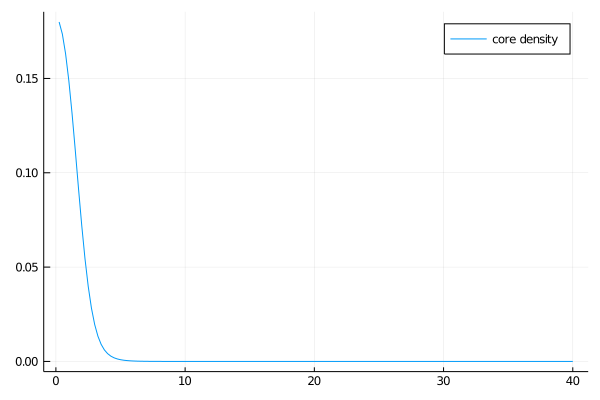

In [11]:
test_calc_density(pars, rs)

# Scattering Cross Section

$r \sim r_\max$において動径波動関数$u(r)$は
$$
    u(r) \sim A \sin(kr - l\pi/2 + \delta),\ \ \ 
    k = \sqrt{\frac{2mE}{\hbar^2}}
$$
と近似できる。したがって、$r_1 = r_\max - \Delta r,\ r_2 = r_\max$とすると、
$$
    \left(
    \begin{array}{c}
        A \sin \delta \\
        A \cos \delta
    \end{array}
    \right)
    = \frac{1}{\sin k(r_2 - r_1)}
    \left(
    \begin{array}{cc}
        \sin (kr_2 - l\pi/2) & -\sin (kr_1 - l\pi/2) \\
        -\cos (kr_2 - l\pi/2) & \cos (kr_1 - l\pi/2)
    \end{array}
    \right)
    \left(
    \begin{array}{c}
        u(r_1) \\
        u(r_2)
    \end{array}
    \right)
$$
となる。この式より散乱断面積
$$
    \sigma = \frac{4\pi(2l+1)}{k^2} \sin^2 \delta
$$
を計算できる。

In [12]:
function calc_sin²δ(pars, rs, vpot, E, qnums)
    u = zeros(Float64, length(rs))
    l = qnums.l
    
    k² = zeros(Float64, length(rs))
    @. k² = - vpot + E*2pars.mc²/pars.ħc^2
    
    S = zeros(Float64, length(rs))
    
    @. u[1:2] = rs[1:2]^l
    for ir in 2:length(rs)-1
        u[ir+1] = numerov(ir, rs, k², S, u[ir-1], u[ir])
    end
    
    k = sqrt(2pars.mc²*E/pars.ħc^2)
    
    r₁ = rs[end-1]; u₁ = u[end-1]
    r₂ = rs[end]; u₂ = u[end]
    Asinδ = (sin(k*r₂ - l*π/2)*u₁ - sin(k*r₁ - l*π/2)*u₂)
    Acosδ = (-cos(k*r₂ - l*π/2)*u₁ + cos(k*r₁ - l*π/2)*u₂)
    
    sin²δ = Asinδ^2/(Asinδ^2 + Acosδ^2)
end

function test_calc_sin²δ(pars, rs; Eres=0.8, Emax=10)
    qnums = My.QuantumNumbers(l=1, j=1, q=1)
    vpot = calc_vpot(pars, rs, qnums) 
    
    E = range(0, Emax, length=500+1)[2:end]
    sin²δ = zeros(Float64, length(E))
    σ = zeros(Float64, length(E))
    
    for i in 1:length(E)
        sin²δ[i] = calc_sin²δ(pars, rs, vpot, E[i], qnums)
    end
    plot(E, sin²δ, label="sin²δ", xlabel="E [MeV]")
    
    plot!([Eres, Eres], [min(sin²δ...), max(sin²δ...)], label="0.8 MeV")
end


test_calc_sin²δ (generic function with 1 method)

  0.015071 seconds (322 allocations: 1.219 MiB)
i = 1
(states[i]).E = -10.935761451854974
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 2
(states[i]).E = -1.2574649043878372
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)



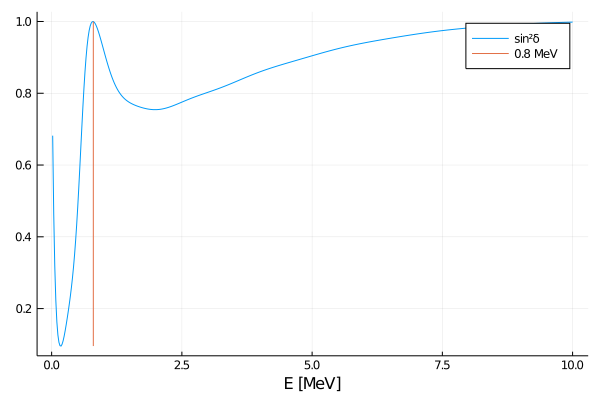

In [13]:
pars = My.Parameters(Z=3, N=8, Vvalence=-30.2)
rs = range(0, 40, length=160+1)[2:end]

@time states = solve_H1d(pars, rs; core=false, proton=false)
show_states(states)

test_calc_sin²δ(pars, rs)

# S-matrix

複素波数$k$に対し、動径方向のシュレーディンガー方程式
$$
    \left(
        - \frac{\hbar^2}{2m} \frac{d^2}{dr^2} + V(r) 
        - \frac{\hbar^2 k^2}{2m}
    \right) u(r) = 0, \ \ \ u(0) = 0
$$
を解くと、十分遠方では
$$
    u(r) \propto e^{ikr} - S(k)^{-1} e^{-ikr}
$$
となる。ここで、$S(k)$はS行列である。

In [127]:
function hankel1(l, ρ)
    if l==1
        return -(1/ρ + im/ρ^2)*exp(im*ρ)
    else
        error("l ≠ 1")
    end
end

function hankel2(l, ρ)
    if l==1
        return -(1/ρ - im/ρ^2)*exp(-im*ρ)
    else
        error("l ≠ 1")
    end
end

function calc_Sinv(pars, rs, vpot, E, qnums)
    u = zeros(Complex{Float64}, length(rs))
    l = qnums.l
    
    k² = zeros(Complex{Float64}, length(rs))
    @. k² = - vpot + E*2pars.mc²/pars.ħc^2
    
    S = zeros(Float64, length(rs))
    
    @. u[1:2] = rs[1:2]^l
    for ir in 2:length(rs)-1
        u[ir+1] = numerov(ir, rs, k², S, u[ir-1], u[ir])
    end
    
    k = sqrt(2pars.mc²*E/pars.ħc^2)
    
    r₁ = rs[end-1];    u₁ = u[end-1]
    r₂ = rs[end];    u₂ = u[end]
    
    A, B = [
        r₁*hankel1(l, k*r₁)    r₁*hankel2(l, k*r₁)
        r₂*hankel1(l, k*r₂)    r₂*hankel2(l, k*r₂)
    ] \ [
        u₁
        u₂
    ]
    
    abs(B/A)
end

function calc_Spole(pars, rs, vpot, qnums; Γ₀=0.3, iter_max=10)
    Γ = Γ₀
    E = 0.0
    Erange = range(0, 1, length=200)
    Γrange = range(0, 1, length=length(Erange))
    Sinv = zeros(Float64, length(Erange))
    
    for iter in 1:iter_max
        for i in 1:length(Erange)
            Sinv[i] = calc_Sinv(pars, rs, vpot, Erange[i] - im*Γ, qnums)
        end
        E = Erange[argmin(Sinv)]
        
        for i in 1:length(Γrange)
            Sinv[i] = calc_Sinv(pars, rs, vpot, E - im*Γrange[i], qnums)
        end
        Γ = Γrange[argmin(Sinv)]
    end
    return E, Γ
end

function test_calc_Sinv(pars, rs)
    qnums = My.QuantumNumbers(l=1, j=1, q=1)
    vpot = calc_vpot(pars, rs, qnums) 
    
    E, Γ = calc_Spole(pars, rs, vpot, qnums)
    @show E Γ
    
    Erange = range(0, 1, length=300+1)[2:end]
    
    Sinv = zeros(Float64, length(Erange))
    for i in 1:length(Erange)
        Sinv[i] = calc_Sinv(pars, rs, vpot, Erange[i] - im*Γ, qnums)
    end
    
    plot(Erange, Sinv, label="Sinv", xlabel="E", title="Γ = $Γ [MeV]")
    
end

test_calc_Sinv (generic function with 1 method)

E = 0.6130653266331658
Γ = 0.31155778894472363


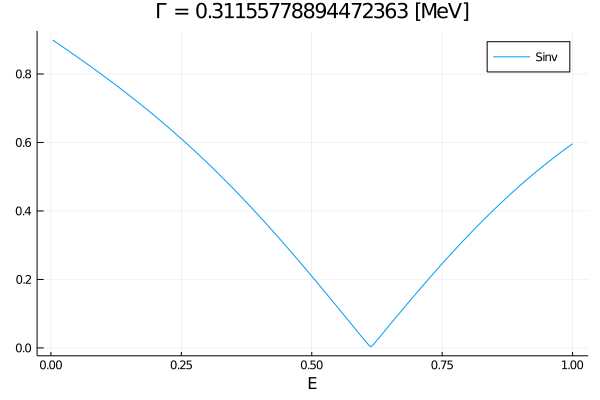

In [130]:
pars = My.Parameters(Z=3, N=8)

rmax = 11
rs = range(0, rmax, length=10rmax+1)[2:end]

test_calc_Sinv(pars, rs)

# Hamiltonian Diagonalization

In [46]:
"""
    make_index(states)

Make index of 2-particle states.
"""
function make_index(states)
    nstates = length(states)
    index = zeros(Int64, 2, 0)
    Ec = 40 # energy cut-off
    for i₁ in 1:nstates
        for i₂ in 1:nstates
            if states[i₁].qnums.l == states[i₂].qnums.l && 
                    states[i₁].qnums.j == states[i₂].qnums.j && 
                    states[i₁].E ≤ states[i₂].E && 
                    states[i₁].E + states[i₂].E ≤ Ec
                
                index = hcat(index, [i₁, i₂])
            end
        end
    end
    return index
end

make_index

In [47]:
"""
    calc_veff(pars, rs, ρ)

Calculate effective interaction between valence neutrons.
"""
function calc_veff(pars, rs, ρ)
    ngrids = length(rs)
    veff = zeros(Float64, ngrids)
    @. veff = pars.v₀ + pars.v_ρ*(ρ/pars.ρ₀)^pars.P
    return veff
end

"""
    make_H₂(pars, rs, states, index)

Make two-body Hamiltonian.
"""
function make_H₂(pars, rs, ρ, states, index)
    ngrids = length(rs)
    nstates = length(states)
    dim = size(index, 2)
    
    veff = calc_veff(pars, rs, ρ)
    
    H₂ = zeros(Float64, dim, dim)
    
    for n in 1:dim
        i₃, i₄ = index[:, n]
        l₃ = states[i₃].qnums.l
        j₃ = states[i₃].qnums.j
        
        H₂[n,n] += states[i₃].E + states[i₄].E
        
        for m in n:dim
            i₁, i₂ = index[:, m]
            l₁ = states[i₁].qnums.l
            j₁ = states[i₁].qnums.j
            
            H₂[m,n] += 
                (-1)^(l₁+l₃) * sqrt((j₁+1)*(j₃+1))/8π *
                simps(rs, @. states[i₁].ψ*states[i₂].ψ*states[i₃].ψ*states[i₄].ψ*veff/rs^2) *
                sqrt(2 - (states[i₁].E==states[i₂].E)) * 
                sqrt(2 - (states[i₃].E==states[i₄].E))
        end
    end
    
    return Symmetric(H₂, :L)
end

"""
    solve_H₂(H₂)

Diagonalize two-body Hamiltonian.
"""
function solve_H₂(H₂)
    @time vals, vecs = eigen(H₂)
    
    return vals[1], vecs[:, 1]
end
            
            
"""
    lanczos(A; maxiter=100)

Calculate minimum eigenvalue of matrix A using Lanczos method.
"""
function lanczos(A; maxiter=100, rtol=1e-4)
    dim = size(A, 1)
    
    α = zeros(Float64, maxiter) # diagonal elements
    β = zeros(Float64, maxiter-1) # first sub/super-diagonal elements
    λ = zeros(Float64, maxiter) # minimum eigenvalues at each iteration
    
    u = zeros(Float64, dim, maxiter+1)
    u[1,1]=1
    
    @views α[1] = u[:,1]'*A*u[:,1]
    @views u[:,2] = A*u[:,1] - α[1]*u[:,1]
    λ[1] = α[1]
    
    iter_break = 0
    for i in 2:maxiter
        @views β[i-1] = norm(u[:,i])
        u[:,i] /= β[i-1]
        
        @views α[i] = u[:,i]'*A*u[:,i]
        @views u[:,i+1] = A*u[:,i] - β[i-1]*u[:,i-1] - α[i]*u[:,i]

        (λ[i], ) = eigvals( SymTridiagonal(α[1:i], β[1:i-1]) )
        
        if abs((λ[i] - λ[i-1])/λ[i]) < rtol
            iter_break = i
            break
        end
    end
    
    return λ[1:iter_break]
end
                

lanczos

In [122]:
pars = My.Parameters(Z=3, N=8)
rs = range(0, 40, length=160+1)[2:end]
ρ = calc_density(pars, rs)

@time states = solve_H1d(pars, rs; Emax=40, Emin=0, lmax=13)
#show_states(states)
index = make_index(states)
@time H₂ = make_H₂(pars, rs, ρ, states, index)

ε_2n, β = solve_H₂(H₂)
@show ε_2n
;

  0.059571 seconds (2.48 k allocations: 7.096 MiB)
  2.841325 seconds (4.07 M allocations: 2.790 GiB, 11.29% gc time)
  2.503624 seconds (15 allocations: 93.840 MiB, 0.22% gc time)
ε_2n = -0.25578997809548554


In [119]:
function show_H₂(H₂)
    for i in 1:100
        println(H₂[i,i])
    end
end

show_H₂(H₂)

0.271006209794679
0.6816675447129371
1.3759255662133856
2.344051149671705
3.583734803181944
5.092524883906136
6.867993236856576
8.90774423773872
11.209374128151554
13.770434569961012
16.58841938756534
19.660773853460284
22.984918360425365
26.558277512603585
30.378307459989006
34.44251663935943
38.74847725950531
0.4781280765355688
0.8180162955676632
1.2798380212586695
2.0817784916622992
3.195867797896021
4.592747336564621
6.261567364973969
8.196008533231174
10.391389916074623
12.84394740038697
15.5505663659044
18.50862510684521
21.715869522388235
25.17030197604394
28.870083654397238
32.81345317897576
36.99866334083052
0.5217287403394755
1.0593716828283597
1.8940113205874596
3.0108191939341715
4.403179585577544
6.0650206127187065
7.991187246175868
10.177362138488048
12.619975747328477
15.316115565150351
18.263416471901284
21.459928884539288
24.90397487222707
28.594009225021335
32.52850194321737
36.70585264402067
0.8326965406246483
1.4552503082580224
2.3262042302657764
3.414294829297108
4

  0.117116 seconds (674 allocations: 5.401 MiB)
λ[end] = -0.25575573471973584


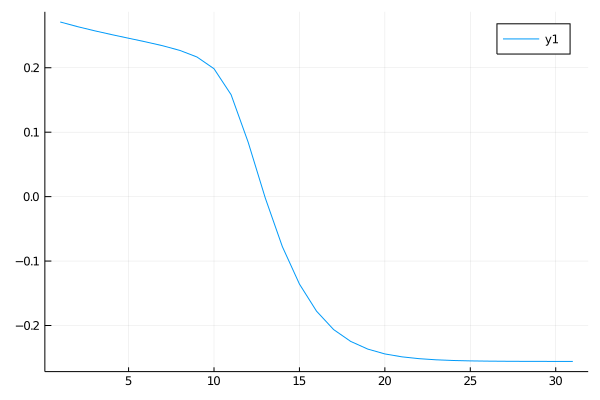

In [62]:
@time λ = lanczos(H₂)
@show λ[end]
plot(λ)

In [120]:
function calc_ρ₂(pars, rs, states, index, β, θ₂)
    ψ₀ = zeros(Float64, length(rs))
    ψ₁ = zeros(Float64, length(rs))
    
    for i in 1:size(index, 2)
        i₁, i₂ = index[:,i]
        l = states[i₁].qnums.l
        j = states[i₁].qnums.j
        
        m = 0
        @. ψ₀ += β[i] * states[i₁].ψ*states[i₂].ψ *
            (-1)^l/2 * sqrt((j+1)/(2l+1)) *
            sqrt((2l+1)/4π*factorial(l-m)/factorial(l+m)) * special.lpmv(m, l, cos(θ₂))::Float64
        
        if l ≥ 1
            m = 1
            @. ψ₁ += β[i] * states[i₁].ψ*states[i₂].ψ *
                (-1)^div(j-1,2)/2 * sqrt(2 - (j+1)/(2l+1)) *
                sqrt((2l+1)/4π*factorial(l-m)/factorial(l+m)) * special.lpmv(m, l, cos(θ₂))::Float64
        end
    end
    
    return @. 1/2π * (ψ₀^2 + ψ₁^2) * (4π)^2
end

function calc_ρ₂(pars, rs, states, index, β)
    θ₂ = range(0, π, length=100)
    ρ₂ = zeros(Float64, length(rs), length(θ₂))
    for i in 1:length(θ₂)
        ρ₂[:, i] = calc_ρ₂(pars, rs, states, index, β, θ₂[i])
    end    
    return ρ₂', θ₂
end
        

calc_ρ₂ (generic function with 2 methods)

  4.778817 seconds (8.07 M allocations: 226.526 MiB, 4.02% gc time)


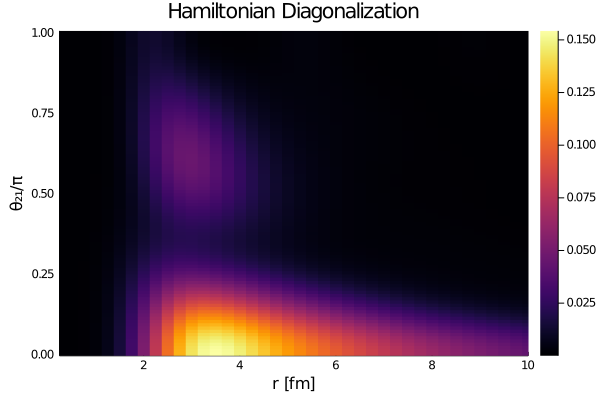

In [123]:
@time ρ₂, θ₂ = calc_ρ₂(pars, rs, states, index, β)
heatmap(rs, θ₂./π, ρ₂, xlabel="r [fm]", ylabel="θ₂₁/π", xlims=(rs[1],10), title="Hamiltonian Diagonalization")

# Green's function method

In [26]:
pars = My.Parameters(Z=3, N=8)
rs = range(0, 40, length=160+1)[2:end]
ρ = calc_density(pars, rs)

@time states = solve_H1d(pars, rs; Emax=40, Emin=0, lmax=5)
show_states(states)
index = make_index(states)

  0.021883 seconds (1.06 k allocations: 2.919 MiB)
i = 1
(states[i]).E = 0.13925017438699483
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 2
(states[i]).E = 0.2422747768365178
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)

i = 3
(states[i]).E = 0.2664660622385586
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)

i = 4
(states[i]).E = 0.42393875634807526
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)

i = 5
(states[i]).E = 0.4240544830661858
(states[i]).qnums = Main.My.QuantumNumbers(2, 3, 1)

i = 6
(states[i]).E = 0.556431865419023
(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 7
(states[i]).E = 0.5977069179367288
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)

i = 8
(states[i]).E = 0.6235070630637455
(states[i]).qnums = Main.My.QuantumNumbers(3, 7, 1)

i = 9
(states[i]).E = 0.623511629709872
(states[i]).qnums = Main.My.QuantumNumbers(3, 5, 1)

i = 10
(states[i]).E = 0.8108884539541048
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)

i = 11
(

(states[i]).qnums = Main.My.QuantumNumbers(0, 1, 1)

i = 109
(states[i]).E = 16.69098122124741
(states[i]).qnums = Main.My.QuantumNumbers(2, 5, 1)

i = 110
(states[i]).E = 17.311040447561
(states[i]).qnums = Main.My.QuantumNumbers(2, 3, 1)

i = 111
(states[i]).E = 17.689391392222678
(states[i]).qnums = Main.My.QuantumNumbers(4, 9, 1)

i = 112
(states[i]).E = 17.792084912987946
(states[i]).qnums = Main.My.QuantumNumbers(4, 7, 1)

i = 113
(states[i]).E = 18.01318423084037
(states[i]).qnums = Main.My.QuantumNumbers(1, 3, 1)

i = 114
(states[i]).E = 18.281333858181203
(states[i]).qnums = Main.My.QuantumNumbers(1, 1, 1)

i = 115
(states[i]).E = 18.792115342714595
(states[i]).qnums = Main.My.QuantumNumbers(3, 7, 1)

i = 116
(states[i]).E = 19.19491688223267
(states[i]).qnums = Main.My.QuantumNumbers(5, 11, 1)

i = 117
(states[i]).E = 19.228555366481782
(states[i]).qnums = Main.My.QuantumNumbers(5, 9, 1)

i = 118
(states[i]).E = 19.253999413904555
(states[i]).qnums = Main.My.QuantumNumbers(3,

2×1115 Array{Int64,2}:
 1  1   1   1   1   1   1   1   1   1  …  114  115  116  117  118  119  120
 1  6  18  29  40  51  62  73  85  97     125  115  116  117  118  119  120

### uncorrelated Green's Function
$$
    G_{2}^{0}(\vec{r}, \vec{r}', E, J=0)
    = \frac{G_2^0(r, r', E)}{r^2 r'^2}
    Y_{00}(\Omega) Y_{00}^{*}(\Omega') \chi_{00} \chi_{00}^\dagger
$$

$$
    G_2^0(r, r', E)
    = \sum_{nn'lj}  \frac{u_{nlj}(r) u_{n'lj}(r) u_{nlj}(r') u_{n'lj}(r')}{\varepsilon_{nlj}^0 + \varepsilon_{n'lj}^0 - E - i\eta} 
    \frac{2j+1}{8\pi}
$$

### matrix g
$$
    g_{ij} 
    = \delta_{ij} 
    + \frac{\Delta r}{r_{i}^2} 
    G_{2}^{0}(r_i, r_j, E) v_{\mathrm{eff}}(r_j)
$$

In [27]:
"""
    make_gmat(pars, rs, states, index, E, η)

make matrix g.
"""
function make_gmat(pars, rs, ρ, states, index, E, η)
    ngrids = length(rs)
    
    veff = calc_veff(pars, rs, ρ)
    
    gmat = zeros(Complex{Float64}, ngrids, ngrids)
    for i in 1:size(index, 2)
        for n in 1:ngrids, m in 1:ngrids
            gmat[m,n] += 
                (2 - (states[index[1,i]].E==states[index[2,i]].E)) *
                (states[index[1,i]].qnums.j+1)/8π *
                (states[index[1,i]].ψ[m]*states[index[2,i]].ψ[m]) *
                (states[index[1,i]].ψ[n]*states[index[2,i]].ψ[n]) /
                (states[index[1,i]].E + states[index[2,i]].E - E - im*η)
        end
    end
                    
    
    return I + (rs[2] - rs[1])*Diagonal(@. 1/rs^2)*gmat*Diagonal(veff)
end


function test_make_gmat(pars, rs, ρ, states)
    veff = calc_veff(pars, rs)
    @time gmat = make_gmat(pars, rs, ρ, states, index, -10, 0.1)
    return gmat
end

test_make_gmat (generic function with 1 method)

### 2-particle wave function
$$
    \psi_{nn'lj}(\vec{r}) 
    = \psi_{nn'lj}(r) Y_{00}(\Omega) \chi_{00}
    \\
    \psi_{nn'lj}(r) = 
    \frac{u_{nlj}(r) u_{n'lj}(r) }{r^2} 
    (-1)^l \sqrt{\frac{2j+1}{8\pi}} 
$$

### amplitude
$$
    \langle \tilde{2p}|2p \rangle
    = \mathrm{Im} 
    \frac{\langle 2p_0|\delta(r_1 - r_2)(1 + G_2^0(E)v_\mathrm{eff})^{-1}|2p\rangle}{\varepsilon_{2p}^{(0)} - E - i\eta}
    \\
    \simeq 
    \mathrm{Im}
    \frac{\sum_{i} \Delta r \,  r_i^2 \, \psi_{2p_0}(r_i) \, g_{ij}^{-1} \, \psi_{2p}(r_j) }{\varepsilon_{2p}^{(0)} - E - i\eta}
$$

In [32]:
function calc_2pwf(rs, states, index, i)
    i₁, i₂ = index[:, i]
    ψ = zeros(Float64, length(rs))
    @. ψ = (-1)^states[i₁].qnums.l * sqrt((states[i₁].qnums.j + 1)/8π) *
        states[i₁].ψ*states[i₂].ψ/rs^2
    return ψ
end

function calc_amplitude(rs, states, index, gmat, ψ₀, ψ, ε, E, η)
    Δr = rs[2] - rs[1]
    A = Δr * (@. rs^2*ψ₀)' * (gmat\ψ) / (ε - E - im*η)
    return imag(A)
end

function test_calc_amplitude(rs, states, ρ, index)
    ψ₀= calc_2pwf(rs, states, index, 1)
    ε = states[index[1,1]].E + states[index[1,1]].E
    
    Es = range(-0.225, -0.223, length=20)
    η = 1e-4
    As = zeros(Float64, length(Es))
    for i in 1:length(Es)
        gmat = make_gmat(pars, rs, ρ, states, index, Es[i], η)
        As[i] = calc_amplitude(rs, states, index, gmat, ψ₀, ψ₀, ε, Es[i], η)
    end
    plot(Es, As, label="Green's Function")
    e = -0.22429214186873736
    plot!([e, e], [min(As...), max(As...)], label="Hamiltonian")
end
    

test_calc_amplitude (generic function with 1 method)

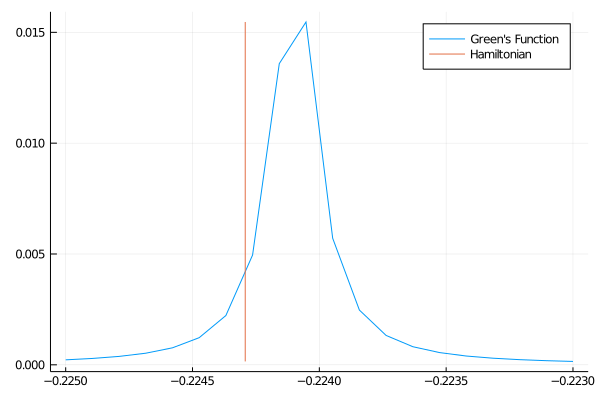

In [33]:
test_calc_amplitude(rs, states, ρ, index)

In [24]:
function calc_β(rs, states, index, gmat, ψ₀, E, η)
    β = zeros(Float64, size(index, 2))
    
    for i in 1:size(index, 2)
        ψ = calc_2pwf(rs, states, index, i)
        ε = states[index[1,i]].E + states[index[2,i]].E
        
        β[i] = 
            calc_amplitude(rs, states, index, gmat, ψ₀, ψ, ε, E, η) * 
            sqrt(1 + (states[index[1,i]].E==states[index[2,i]].E))
        
    end
    
    β /= sqrt(β'*β)
    
    return β
end

function test_calc_β(rs, ρ, states, index)
    E = -0.22429214186873736
    η = 1e-5
    gmat = make_gmat(pars, rs, ρ, states, index, E, η)
    ψ₀ = calc_2pwf(rs, states, index, 1)
    @time β = calc_β(rs, states, index, gmat, ψ₀, E, η)
    
    @time ρ₂, θ₂ = calc_ρ₂(pars, rs, states, index, β)
    heatmap(rs, θ₂./π, ρ₂, xlabel="r[fm]", ylabel="θ₂₁/π", xlims=(rs[1],10), title="Green's Function")
end
    

test_calc_β (generic function with 1 method)

  2.137642 seconds (20.17 k allocations: 804.018 MiB, 5.72% gc time)
  4.189590 seconds (8.04 M allocations: 225.197 MiB, 4.47% gc time)


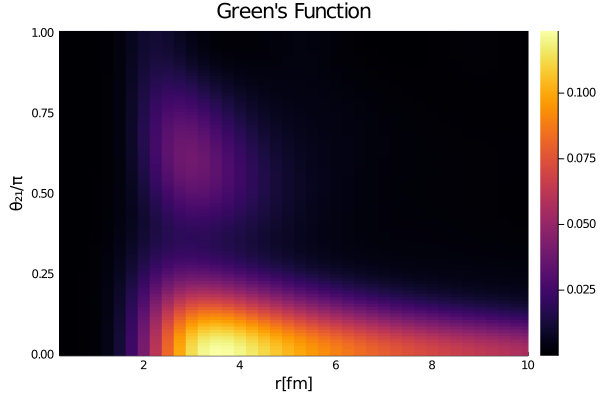

In [25]:
test_calc_β(rs, ρ, states, index)